In [3]:
import numpy as np
from keras.models import Sequential, Model
from keras.layers import Embedding, Reshape, Activation, Input, Dense, Dropout, LSTM, GlobalMaxPooling1D
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import skipgrams
from keras.layers import dot
import gensim
from numpy import dot
from numpy.linalg import norm
import tensorflow as tf

from sklearn.metrics import precision_recall_fscore_support
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Flatten, Dense
import re
import os
from keras.preprocessing.text import Tokenizer

import random
from gensim.models import Word2Vec

import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

from collections import Counter


from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam





In [4]:
# Check tf version
print(tf.__version__)
# Check GPU availability
print(tf.test.gpu_device_name())
print(tf.config.list_physical_devices('GPU'))

2.9.3

[]


In [5]:
group_code = "999" # TODO Replace 

# I. PreProcesing

In [6]:
def processing_text(texto):
    # Paso 1: Remover con un expresión regular carateres especiales (no palabras).
    processed_feature = re.sub(r'\W', ' ', str(texto))
    # Paso 2: Remover ocurrencias de caracteres individuales
    processed_feature= re.sub(r'\s+[a-zA-Z]\s+', ' ', processed_feature)
    processed_feature = re.sub(r'\^[a-zA-Z]\s+', ' ', processed_feature)
    # Paso 3: Remover números (Ocurrencias muy esporádicas en nuestro dataset)
    processed_feature = re.sub(r'[0-9]+', ' ', processed_feature)
    # Paso 4: Simplificar espacios concecutivos a un único espacio entre palabras
    processed_feature = re.sub(' +', ' ', processed_feature)
    # Paso 5: Pasar todo el texto a minúsculas
    processed_feature = processed_feature.lower()

    return processed_feature

In [7]:
def generate_corpus_from_folder(folder_path):
    all_files = os.listdir(folder_path)
    corpus = []

    # Process each file
    for file in all_files:
        if file.endswith(".txt"):  # Assuming all your books are in .txt format
            with open(os.path.join(folder_path, file), 'r', encoding="utf-8") as book:
                lines = book.readlines()
                corpus.extend([processing_text(sentence) for sentence in lines])

    # Filter the corpus
    corpus = [sentence for sentence in corpus if sentence!=' ' and sentence!='' and len(sentence.split())>3]
    
    return corpus

folder_path = "data"
corpus = generate_corpus_from_folder(folder_path)
# Tokenize sentences from the corpus
sentences = [sentence.split() for sentence in corpus]

tokenizer = Tokenizer()
tokenizer.fit_on_texts(corpus)
vocab_size = len(tokenizer.word_index) + 1
sequences = tokenizer.texts_to_sequences(corpus)

In [8]:
print(vocab_size)
print(sequences[:5])
corpus[:5]

27609
[[1, 96, 89, 634, 3, 2325], [23, 634, 11, 12, 1, 280, 3, 934, 1387, 5, 1, 459, 391, 2], [139, 93, 1105, 3, 1, 237, 25, 44, 1681, 2, 10, 363, 44, 3139], [2326, 14, 59, 606, 8, 197, 8, 142, 31, 1474, 280, 8, 245, 1, 333], [3, 1, 96, 89, 512, 2132, 10, 23, 634, 31, 1832]]


[' the project gutenberg ebook of dracula ',
 'this ebook is for the use of anyone anywhere in the united states and ',
 'most other parts of the world at no cost and with almost no restrictions ',
 'whatsoever you may copy it give it away or re use it under the terms ',
 'of the project gutenberg license included with this ebook or online ']

#  II. Training Word2Vec models

In [9]:
def train_word2vec_model(sentences, vector_size=100, window=5, min_count=5, workers=4, n_epochs=100):

    # Define Word2Vec model
    model = Word2Vec(sentences, vector_size=vector_size, window=window, min_count=min_count, workers=workers)
    model.train(sentences,total_examples=len(sentences),epochs=n_epochs)
    # Save the model
    model.save(f"Books_{vector_size}_{group_code}.model")
    print(f"Modelo guardado en Books_{vector_size}_{group_code}.model")


In [10]:
dimensionalities = [100, 150, 200]

for dim in dimensionalities:
    train_word2vec_model(sentences, vector_size=dim, window=5, min_count=5, workers=6, n_epochs=150)

Modelo guardado en Books_100_999.model
Modelo guardado en Books_150_999.model
Modelo guardado en Books_200_999.model


In [11]:
def load_word2vec_model(model_dim: int)->Word2Vec:
    """ 
    Load a Word2Vec model from disk
    Args:
        model_dim: Dimensionality of the model to load
    Ret: 
        Word2Vec model
    """
    model = Word2Vec.load(f"Books_{model_dim}_{group_code}.model")
    return model

In [12]:
#Load the 150 dimensional model
embedding_dim = 100
model = load_word2vec_model(embedding_dim)

In [13]:
similar_words = model.wv.most_similar('lion', topn=10)

similar_words

[('swain', 0.5050688982009888),
 ('hind', 0.472262442111969),
 ('boar', 0.46949902176856995),
 ('mountain', 0.46392396092414856),
 ('blasts', 0.44912412762641907),
 ('victor', 0.42953503131866455),
 ('whirlwind', 0.4178183674812317),
 ('foe', 0.4166119396686554),
 ('hero', 0.4040895402431488),
 ('bull', 0.4003598690032959)]

In [14]:
def plot_similar_words(model, word, topn=10):
    # Get the most similar words
    similar_words = model.wv.most_similar(word, topn=topn)
    
    # Get vectors for each word
    words = [word] + [item[0] for item in similar_words]
    print(words)
    vectors = [model.wv[word]] + [model.wv[item[0]] for item in similar_words]

    # Reduce dimensionality
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(vectors)

    # Plot
    plt.figure(figsize=(10, 6))
    for i, word_i in enumerate(words):
        plt.scatter(pca_result[i, 0], pca_result[i, 1])
        plt.text(pca_result[i, 0]+0.02, pca_result[i, 1]+0.02, word_i, fontsize=12)
    plt.title(f"Words similar to '{word}'")
    plt.show()

### Plots for the main Characters of the books of Bram Stoker

['dracula', 'confine', 'shorthand', 'tones', 'castle', 'low', 'alteration', 'near', 'sketch', 'east', 'airy']


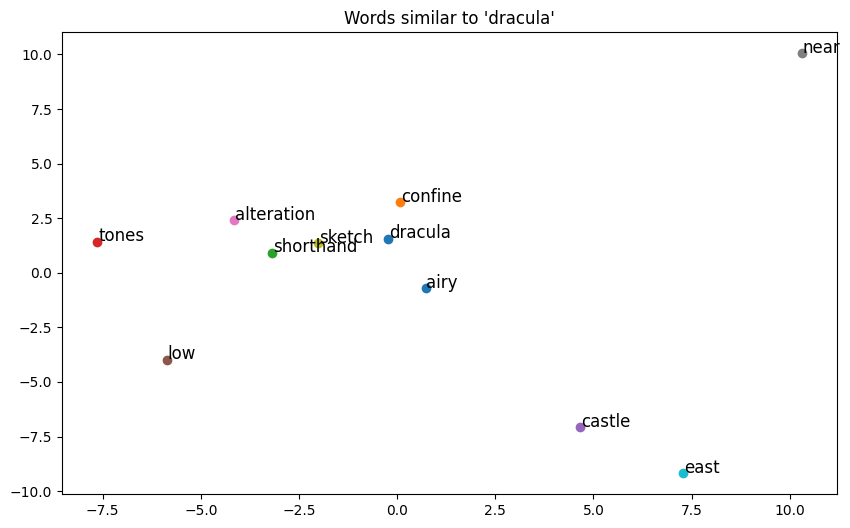

In [15]:
# Use the function
plot_similar_words(model, 'dracula', topn=10)

['tera', 'she', 'stele', 'coffer', 'claimed', 'jewels', 'hotel', 'margaret', 'union', 'cyprian', 'dreaming']


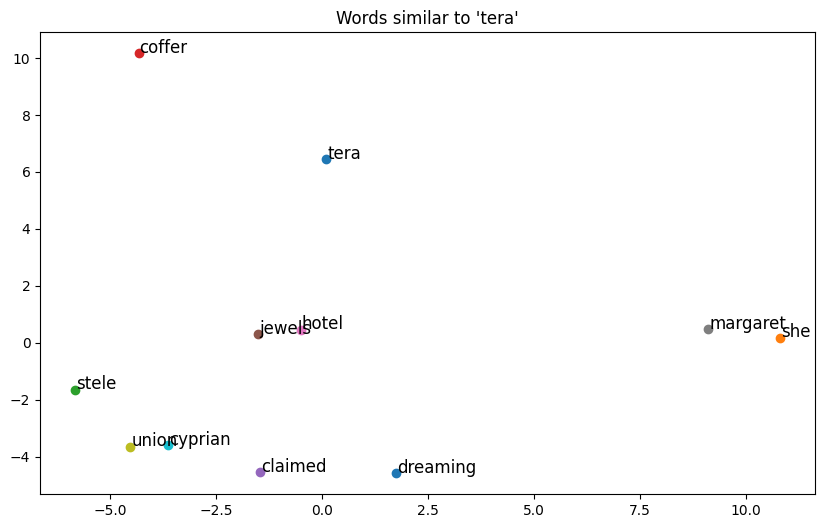

In [16]:
plot_similar_words(model, 'tera', topn=10)

['salton', 'morris', 'trelawny', 'otis', 'ross', 'gray', 'grand', 'corbeck', 'sir', 'caswall', 'winchester']


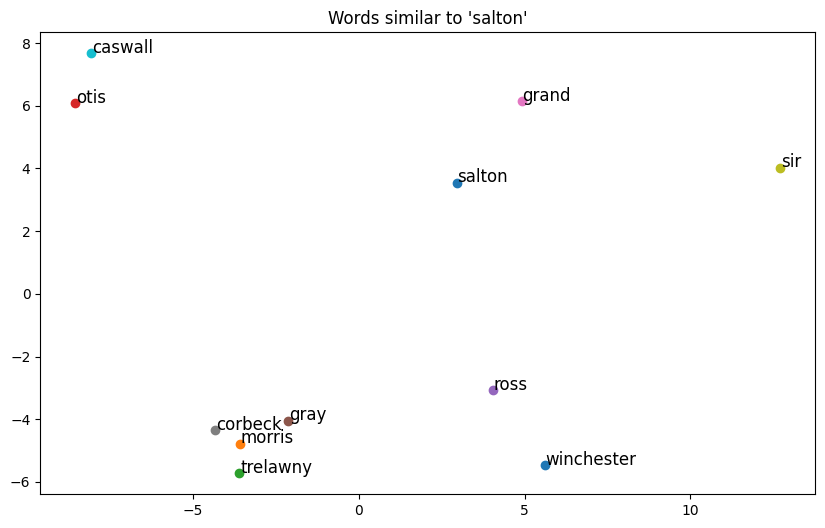

In [17]:
plot_similar_words(model, 'salton', topn=10)

### Plots for the main Characters of the books of Homero

['polynices', 'princes', 'deserving', 'crete', 'foeman', 'bulwark', 'leader', 'thebes', 'altar', 'danaus', 'forceful']


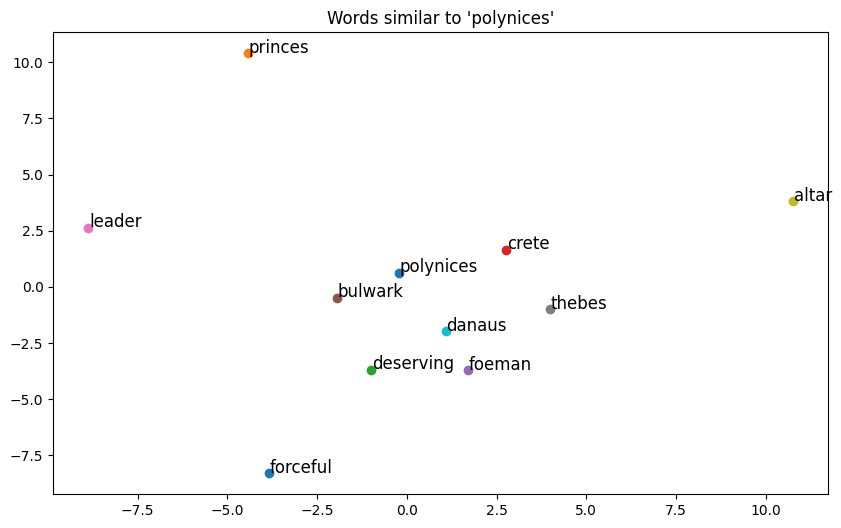

In [18]:
plot_similar_words(model, 'polynices', topn=10)

['helen', 'apollo', 'agamemnon', 'king', 'ne', 'patroclus', 'hermes', 'orestes', 'goddess', 'thetis', 'jason']


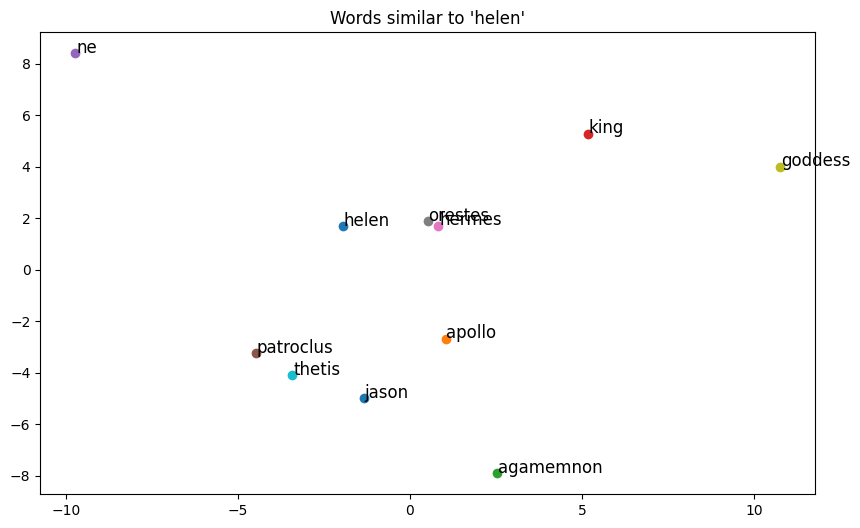

In [19]:
plot_similar_words(model, 'helen', topn=10)

['euripides', 'poet', 'tradition', 'dindorf', 'elegant', 'sqq', 'acquired', 'plato', 'aristotle', 'homer', 'dionys']


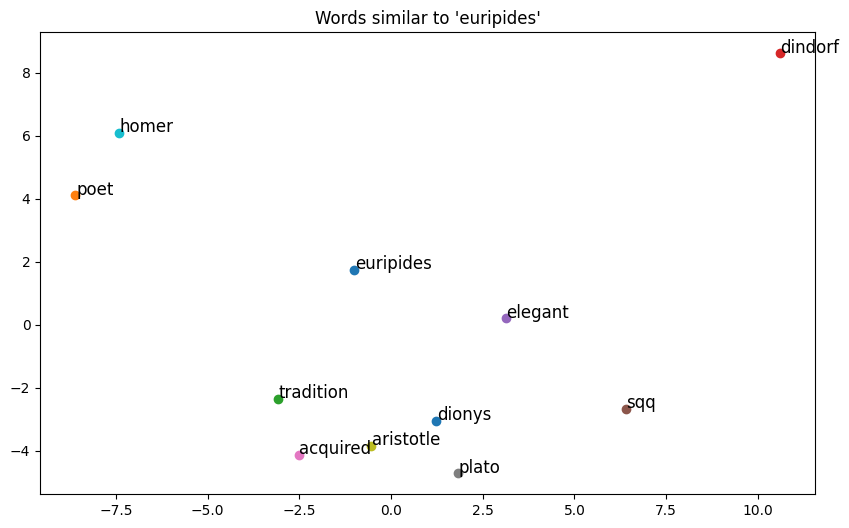

In [20]:
plot_similar_words(model, 'medea', topn=10)

In [ ]:
plot_similar_words(model, 'troyans', topn=10)

### Plots for the main Characters of the books of Oscar Wild

['chiltern', 'basildon', 'goring', 'markby', 'oh', 'cheveley', 'caversham', 'you', 'phipps', 'marchmont', 'dear']


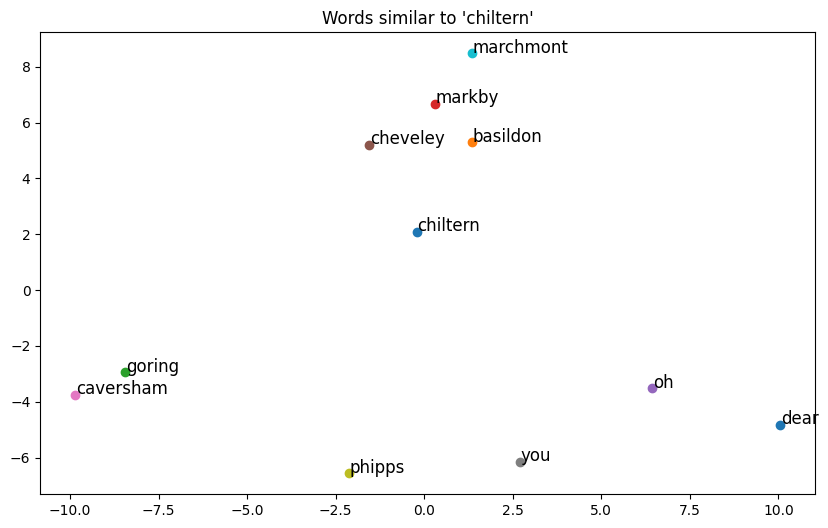

In [21]:
plot_similar_words(model, 'chiltern', topn=10)

['gray', 'montford', 'trelawny', 'trafford', 'otis', 'hallward', 'corbeck', 'marvin', 'morris', 'campbell', 'ashton']


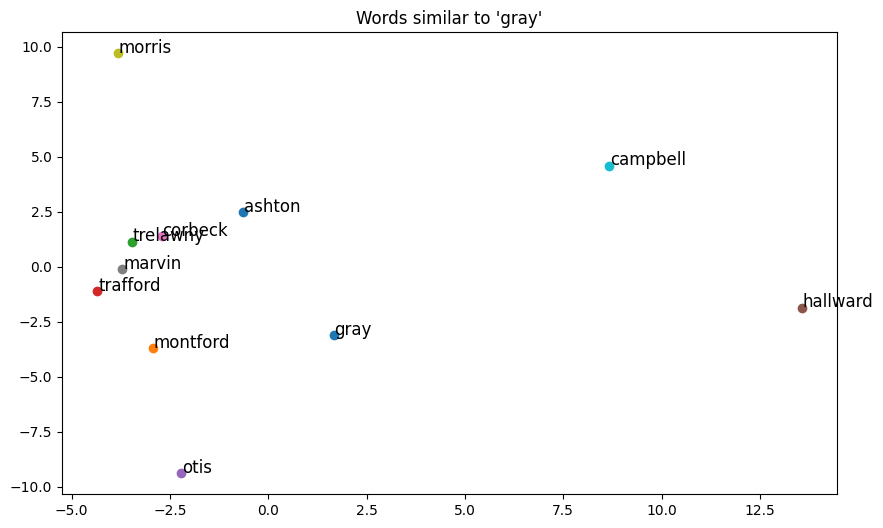

In [22]:
plot_similar_words(model, 'gray', topn=10)

['jokanaan', 'kiss', 'salomé', 'vaunt', 'speakest', 'adm', 'tresses', 'dismal', 'ringlets', 'herodias', 'pr']


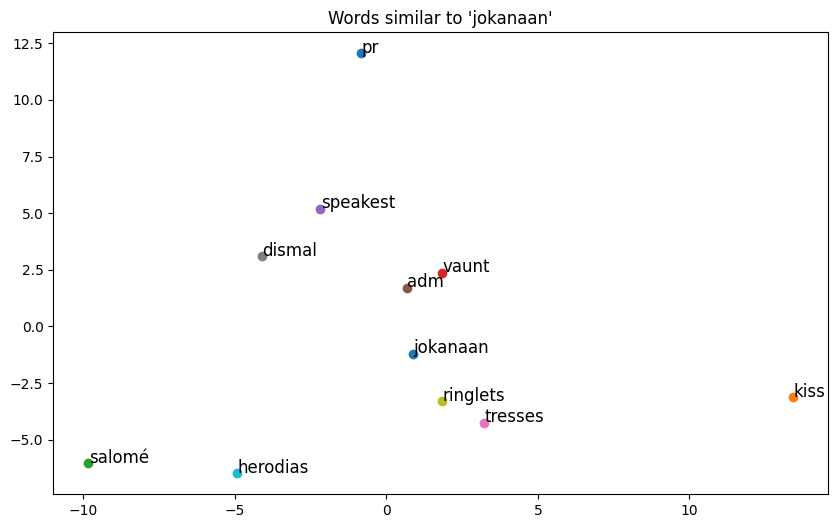

In [23]:
plot_similar_words(model, 'jokanaan', topn=10)

In [24]:
model.wv.most_similar(positive=['woman', 'king'], negative=['man'], topn=10)

[('hecuba', 0.4319767653942108),
 ('daughters', 0.43032145500183105),
 ('love', 0.39810994267463684),
 ('herodias', 0.39748045802116394),
 ('goddess', 0.3868102431297302),
 ('fairest', 0.3848699629306793),
 ('latona', 0.38156405091285706),
 ('vilest', 0.37310361862182617),
 ('among', 0.3671848773956299),
 ('peleus', 0.36184388399124146)]

In [25]:
def cosine_similarity_tensor(v1, v2):
    normalized_v1 = tf.nn.l2_normalize(v1, axis=-1)
    normalized_v2 = tf.nn.l2_normalize(v2, axis=-1)
    return tf.reduce_sum(tf.multiply(normalized_v1, normalized_v2))

# Convert embeddings to tensors
tensor_king = tf.convert_to_tensor(model.wv['king'])
tensor_man = tf.convert_to_tensor(model.wv['man'])
tensor_queen = tf.convert_to_tensor(model.wv['queen'])
tensor_woman = tf.convert_to_tensor(model.wv['woman'])

queen_rep_tensor = (tensor_king - tensor_man) + tensor_woman

similarity_score_tensor = cosine_similarity_tensor(queen_rep_tensor, tensor_queen)

print(similarity_score_tensor.numpy())


0.2721207


#  III. Classification

In [26]:
# Create books_by_author is a dict with author names as keys and lists of text segments as values
# e.g., {"Author1": ["text segment 1", "text segment 2", ...], "Author2": [...], ...}

books_by_author = {}
for file in os.listdir(folder_path):
    if file.endswith(".txt"):  # Assuming all your books are in .txt format
        with open(os.path.join(folder_path, file), 'r', encoding="utf-8") as book:
            author = file.split("___")[0]
            if author in books_by_author:
                books_by_author[author].append(book.read())
            else:
                books_by_author[author] = [book.read()]

books_by_author.keys()

dict_keys(['bram_stoker', 'homer', 'oscar_wild'])

In [27]:


segments = []
labels = []
segment_size = 225  
# Segment books and create labels
for author, books in books_by_author.items():
    for book in books:
        words = book.split()
        for i in range(0, len(words), segment_size):  # Step of 225 to get segments of 150-250 words
            segment = ' '.join(words[i:i+segment_size])
            segments.append(segment)
            labels.append(author)

# Shuffle segments and labels together
combined = list(zip(segments, labels))
random.shuffle(combined)
segments, labels = zip(*combined)

# Split into train, validation, and test sets
train_size = int(0.8 * len(segments))
val_size = int(0.1 * len(segments))
train_segments, train_labels = segments[:train_size], labels[:train_size]
val_segments, val_labels = segments[train_size:train_size+val_size], labels[train_size:train_size+val_size]
test_segments, test_labels = segments[train_size+val_size:], labels[train_size+val_size:]

# Create summary table
print("Training:", Counter(train_labels))
print("Validation:", Counter(val_labels))
print("Testing:", Counter(test_labels))

Training: Counter({'homer': 1360, 'bram_stoker': 1124, 'oscar_wild': 508})
Validation: Counter({'homer': 173, 'bram_stoker': 128, 'oscar_wild': 73})
Testing: Counter({'homer': 163, 'bram_stoker': 151, 'oscar_wild': 60})


## Train Keras Models

### Architecture 1

In [28]:
def generate_model_1(vocab_size: int, embedding_dim: int, segment_size: int, trainable: bool=True, embedding_matrix=None)->Sequential:
    """
    Generate a Keras Sequential model with the following architecture:
    - Embedding layer with vocab_size, embedding_dim, and input_length=segment_size
    - Flatten layer
    - Dense layer with 128 units and relu activation
    - Dense layer with 3 units and softmax activation
    Args:
        vocab_size: Size of the vocabulary
        embedding_dim: Dimensionality of the embedding
        segment_size: Length of the input text segments
    Ret:
        Keras Sequential model
    """
    if trainable:
        model = Sequential([
            Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=segment_size, trainable=trainable),
            Flatten(),
            Dense(128, activation='relu'),
            Dense(3, activation='softmax')  # For 3 authors
        ])
    else:
        model = Sequential([
            Embedding(input_dim=vocab_size, output_dim=embedding_dim, weights=[embedding_matrix], input_length=segment_size, trainable=trainable),
            Flatten(),
            Dense(128, activation='relu'),
            Dense(3, activation='softmax')  # For 3 authors
        ])
    return model

model_1 = generate_model_1(vocab_size, embedding_dim, segment_size)
model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 225, 100)          2760900   
                                                                 
 flatten (Flatten)           (None, 22500)             0         
                                                                 
 dense (Dense)               (None, 128)               2880128   
                                                                 
 dense_1 (Dense)             (None, 3)                 387       
                                                                 
Total params: 5,641,415
Trainable params: 5,641,415
Non-trainable params: 0
_________________________________________________________________


### Architecture 2


In [29]:
def generate_model_2(vocab_size: int, embedding_dim: int,  segment_size: int, trainable: bool = True, embedding_matrix = None)->Sequential:
    """
    Generate a Sequential model with the following architecture:
    - Embedding layer with input_dim=vocab_size, output_dim=embedding_dim, input_length=250
    - Flatten layer
    - Dense layer with 256 units and relu activation
    - Dense layer with 128 units and relu activation
    - Dense layer with 64 units and relu activation
    - Dense layer with 3 units and softmax activation
    Args:
        vocab_size: Size of the vocabulary
        embedding_dim: Dimensionality of the embedding layer
        segment_size: Length of the input text segments
    Ret:
        Sequential model
    """
    if trainable:
        model = Sequential([
            Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=segment_size, trainable=trainable),
            Flatten(),
            Dense(256, activation='relu'),
            Dense(128, activation='relu'),
            Dense(64, activation='relu'),
            Dense(3, activation='softmax')
        ])
    else:
        model = Sequential([
            Embedding(input_dim=vocab_size, output_dim=embedding_dim, weights=[embedding_matrix], input_length=segment_size, trainable=trainable),
            Flatten(),
            Dense(256, activation='relu'),
            Dense(128, activation='relu'),
            Dense(64, activation='relu'),
            Dense(3, activation='softmax')
        ])
    return model

model_2 = generate_model_2(vocab_size, embedding_dim, segment_size)
model_2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 225, 100)          2760900   
                                                                 
 flatten_1 (Flatten)         (None, 22500)             0         
                                                                 
 dense_2 (Dense)             (None, 256)               5760256   
                                                                 
 dense_3 (Dense)             (None, 128)               32896     
                                                                 
 dense_4 (Dense)             (None, 64)                8256      
                                                                 
 dense_5 (Dense)             (None, 3)                 195       
                                                                 
Total params: 8,562,503
Trainable params: 8,562,503
No

### Architecture 3

In [30]:
def generate_model_3(vocab_size: int, embedding_dim: int,  segment_size: int, trainable:bool=True, embedding_matrix = None)->Sequential:
    """
    Generate a Sequential model with the following architecture:
    - Embedding layer with input_dim=vocab_size, output_dim=embedding_dim, input_length=250
    - Flatten layer
    - LSTM layer with 128 units, return_sequences=True anddropout=0.2
    - GlobalMaxPooling1D layer
    - Dense layer with 64 units and relu activation
    - Dense layer with 3 units and softmax activation
    Args:
        vocab_size: Size of the vocabulary
        embedding_dim: Dimensionality of the embedding layer
        segment_size: Length of the input text segments
    Ret:
        Sequential model
    """
    if trainable:
        model = Sequential([
            Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=segment_size, trainable=trainable),
            LSTM(128,return_sequences=True,dropout=0.2),
            GlobalMaxPooling1D(),
            Dense(64, activation='relu'),
            Dropout(0.1),
            Dense(3, activation='softmax')
        ])
    else:
        model = Sequential([
            Embedding(input_dim=vocab_size, output_dim=embedding_dim, weights=[embedding_matrix], input_length=segment_size, trainable=trainable),
            LSTM(128,return_sequences=True,dropout=0.2),
            GlobalMaxPooling1D(),
            Dense(64, activation='relu'),
            Dropout(0.1),
            Dense(3, activation='softmax')
        ])
    return model

model_3 = generate_model_3(vocab_size, embedding_dim, segment_size)
model_3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 225, 100)          2760900   
                                                                 
 lstm (LSTM)                 (None, 225, 128)          117248    
                                                                 
 global_max_pooling1d (Globa  (None, 128)              0         
 lMaxPooling1D)                                                  
                                                                 
 dense_6 (Dense)             (None, 64)                8256      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_7 (Dense)             (None, 3)                 195       
                                                      

## Train each arch with the 3 diferent classes of embeddings dims


In [31]:
def load_embedding_matrix(word2vec_model, tokenizer, embedding_dim):
    """
    Load the embedding matrix from a Word2Vec model
    Args:
        word2vec_model: Word2Vec model
        tokenizer: Keras tokenizer
        embedding_dim: Dimensionality of the embedding
    Ret:
        Embedding matrix
    """
    vocab_size = len(tokenizer.word_index) + 1
    embedding_matrix = np.zeros((vocab_size, embedding_dim))

    for word, i in tokenizer.word_index.items():
        if word in word2vec_model.wv:
            embedding_matrix[i] = word2vec_model.wv[word]

    return embedding_matrix

# Tokenize and convert text to sequences
#tokenizer = Tokenizer()
#tokenizer.fit_on_texts(train_segments)
label_mapping = {'bram_stoker': 0, 'homer': 1, 'oscar_wild': 2}
train_sequences = tokenizer.texts_to_sequences(train_segments)
val_sequences = tokenizer.texts_to_sequences(val_segments)
test_sequences = tokenizer.texts_to_sequences(test_segments)

In [32]:
def generate_trained_model (model_kind:str, embedding_dim: int,
                            train_segments: list, train_labels: list, val_segments: list, 
                             val_labels: list, epochs: int, batch_size: int, trainable: bool = True, embedding_matrix=None)->Sequential:
    """
    Generate a trained model
    Args:
        model_kind: Kind of model to train (1 or 2 or 3)
        embedding_dim: Dimensionality of the embedding layer
        train_segments: List of training segments
        train_labels: List of training labels
        val_segments: List of validation segments
        val_labels: List of validation labels
        epochs: Number of epochs
        batch_size: Batch size
    Ret:
        Trained Keras Sequential model
    """

    embeding = load_word2vec_model(embedding_dim)
    segment_size = len(train_segments[0])
    model = None
    # Define the model
    if model_kind == '1':
        model = generate_model_1(vocab_size, embedding_dim, segment_size, trainable, embedding_matrix)
    elif model_kind == '2':
        model = generate_model_2(vocab_size, embedding_dim, segment_size, trainable, embedding_matrix)
    else:
        model = generate_model_3(vocab_size, embedding_dim, segment_size, trainable, embedding_matrix)
        
    # Pad sequences
    train_padded = pad_sequences(train_sequences, padding='post', maxlen=segment_size)
    val_padded = pad_sequences(val_sequences, padding='post', maxlen=segment_size)

    label_mapping = {'bram_stoker': 0, 'homer': 1, 'oscar_wild': 2}
    train_labels = [label_mapping[label] for label in train_labels]
    val_labels = [label_mapping[label] for label in val_labels]


    train_padded = np.array(train_padded)
    val_padded = np.array(val_padded)
    train_labels = np.array(train_labels)
    val_labels = np.array(val_labels)

    # Load the embedding matrix
    embedding_matrix = load_embedding_matrix(embeding, tokenizer, embedding_dim)
 
     # Assign the embedding weights to the model's embedding layer
    model.layers[0].set_weights([embedding_matrix])
    model.layers[0].trainable = False  # Freeze the embedding layer

    # Compile and train the model
    model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    history = model.fit(train_padded, train_labels, validation_data=(val_padded, val_labels), epochs=epochs, batch_size=batch_size)

    return model, history


In [33]:
def evaluate_model(model, test_sequences, test_labels, label_mapping, segment_size):
    """
    Evaluate a model on a test set
    Args:
        model: Trained Keras model
        test_segments: List of test segments
        test_labels: List of test labels
        label_mapping: Dictionary mapping labels to integers
        segment_size: The length to which sequences should be padded or truncated
    Returns:
        Accuracy on the test set
    """
    # Pad sequences
    test_padded = pad_sequences(test_sequences, padding='post', maxlen=segment_size)
    
    # Encode labels
    test_labels_encoded = [label_mapping[label] for label in test_labels]

    test_padded = np.array(test_padded)
    test_labels_encoded = np.array(test_labels_encoded)

    # Evaluate the model
    loss, accuracy = model.evaluate(test_padded, test_labels_encoded)

    # Generate confusion matrix
    predictions = model.predict(test_padded)
    predictions = np.argmax(predictions, axis=1)
    confusion_matrix = tf.math.confusion_matrix(test_labels_encoded, predictions)
    
    # Extract f1, precision, and recall using SKLearn
    precision, recall, f1, _ = precision_recall_fscore_support(test_labels_encoded, predictions, average='macro')
    print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}")

    return accuracy, precision, recall, f1, confusion_matrix


In [34]:
def plot_history(history, save_path, title):
    """
    Create a okit the accuracy and loss of a trained model
    and save it to disk
    Args:
        history: Keras history object
    """
    plt.figure(figsize=(10, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train')
    plt.plot(history.history['val_accuracy'], label='Validation')
    plt.title('Accuracy '+str(title))
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train')
    plt.plot(history.history['val_loss'], label='Validation')
    plt.title('Loss '+str(title))
    plt.legend()
    plt.savefig(save_path)


### Generate and test all the different kind of models

-----------------------------------
Dimentionality 200
Epoch 1/10
94/94 [==============================] - 23s 238ms/step - loss: 0.5732 - accuracy: 0.7945 - val_loss: 0.3088 - val_accuracy: 0.8743
Epoch 2/10
94/94 [==============================] - 21s 220ms/step - loss: 0.0821 - accuracy: 0.9793 - val_loss: 0.6160 - val_accuracy: 0.8449
Epoch 3/10
94/94 [==============================] - 21s 220ms/step - loss: 0.0407 - accuracy: 0.9933 - val_loss: 0.7001 - val_accuracy: 0.8529
Epoch 4/10
94/94 [==============================] - 21s 224ms/step - loss: 0.0118 - accuracy: 0.9977 - val_loss: 0.4892 - val_accuracy: 0.8690
Epoch 5/10
94/94 [==============================] - 20s 215ms/step - loss: 0.0051 - accuracy: 0.9993 - val_loss: 0.5341 - val_accuracy: 0.8663
Epoch 6/10
94/94 [==============================] - 21s 220ms/step - loss: 0.0026 - accuracy: 0.9997 - val_loss: 0.5034 - val_accuracy: 0.8690
Epoch 7/10
94/94 [==============================] - 20s 213ms/step - loss: 0.0017 - acc

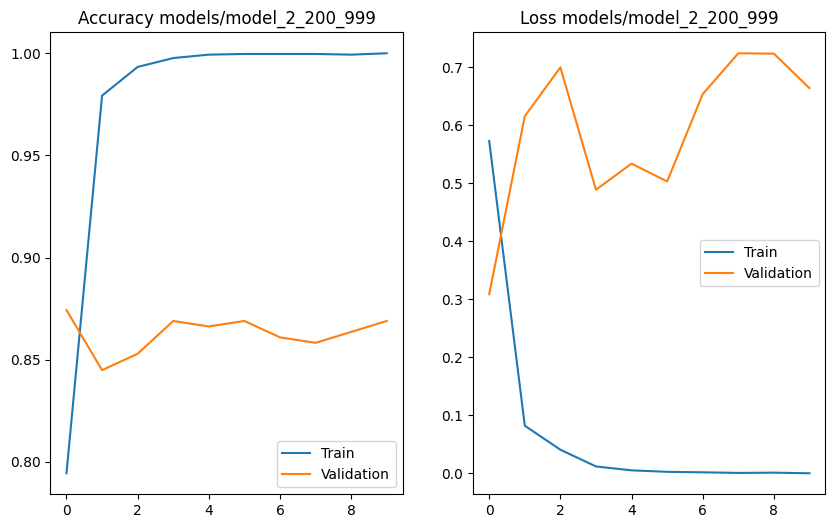

In [37]:
#%%time

models_dir = "models"
os.makedirs(models_dir, exist_ok=True)
for embedding_dim in dimensionalities[-1:]:
    print("-----------------------------------")
    print("Dimentionality", embedding_dim)
    for model_kind in ['1', '2','3'][-2:-1]: # TODO: agregar '3'
        segment_size = len(train_segments[0])
        epochs = 10
        batch_size = 32


        model, history = generate_trained_model(model_kind, embedding_dim, train_segments, train_labels, val_segments, val_labels,\
                                                 epochs, batch_size)
        accuracy, precision, recall, f1, confusion_matrix = evaluate_model(model, test_sequences, test_labels, label_mapping, segment_size)
        print(f"Test accuracy for model {model_kind} with embedding dimension {embedding_dim}: {accuracy:.4f}")
        print()
        
        # Create a directory to save the model
        model_dir = f"{models_dir}/model_{model_kind}_{embedding_dim}_{group_code}"
        os.makedirs(model_dir, exist_ok=True)
        model.save(os.path.join(model_dir, "model.h5"))

        
        # Plot and save the history
        plot = plot_history(history, os.path.join(model_dir, "history.png"), model_dir)

        # Save history as text
        with open(os.path.join(model_dir, "history.txt"), 'w') as f:
            f.write(str(history.history))
        
        # Save confusion matrix as text
        with open(os.path.join(model_dir, "confusion_matrix.txt"), 'w') as f:
            f.write(str(confusion_matrix.numpy()))

        # Save metrics the metrics as text
        with open(os.path.join(model_dir, "metrics.txt"), 'w') as f:
            f.write(f"Accuracy: {accuracy:.4f}\n")
            f.write(f"Precision: {precision:.4f}\n")
            f.write(f"Recall: {recall:.4f}\n")
            f.write(f"F1: {f1:.4f}\n")
            
        
        

# IV. Pre-trained Embeddings

In [38]:
import gensim.downloader
# Show all available models in gensim-data
print(list(gensim.downloader.info()['models'].keys()))

['fasttext-wiki-news-subwords-300', 'conceptnet-numberbatch-17-06-300', 'word2vec-ruscorpora-300', 'word2vec-google-news-300', 'glove-wiki-gigaword-50', 'glove-wiki-gigaword-100', 'glove-wiki-gigaword-200', 'glove-wiki-gigaword-300', 'glove-twitter-25', 'glove-twitter-50', 'glove-twitter-100', 'glove-twitter-200', '__testing_word2vec-matrix-synopsis']


In [39]:
# Embeddings
print("word2vec-google-news-300")
word2vec_vectors = gensim.downloader.load('word2vec-google-news-300')

word2vec-google-news-300
[==================================================] 100.0% 1662.8/1662.8MB downloaded


In [40]:
print("glove-wiki-gigaword-100")
glove100_vectors = gensim.downloader.load('glove-wiki-gigaword-100')

glove-wiki-gigaword-100
[==================================================] 100.0% 128.1/128.1MB downloaded


In [49]:
print("glove-twitter-200")
glove25_vectors = gensim.downloader.load('glove-twitter-200')

glove-twitter-200


In [42]:
print("word2vec-google-news-300")
print('Loaded %s word vectors.' % len(word2vec_vectors))
print()
print("glove-wiki-gigaword-100")
print('Loaded %s word vectors.' % len(glove100_vectors))
print()
print("glove-twitter-200")
print('Loaded %s word vectors.' % len(glove25_vectors))

word2vec-google-news-300
Loaded 3000000 word vectors.

glove-wiki-gigaword-100
Loaded 400000 word vectors.

glove-twitter-200
Loaded 1193514 word vectors.


In [43]:
len(tokenizer.word_index.items())

27608

In [44]:
embeddings_matrix_word2vec = dict()
for word, i in tokenizer.word_index.items():
    try:
        word2vec_vectors[word]
        embeddings_matrix_word2vec[i] = word2vec_vectors[word]
    except:
        pass
len(embeddings_matrix_word2vec)

20451

In [45]:
embeddings_matrix_glove100 = dict()
for word, i in tokenizer.word_index.items():
    try:
        glove100_vectors[word]
        embeddings_matrix_glove100[i] = glove100_vectors[word]
    except:
        pass
len(embeddings_matrix_glove100)

22061

In [46]:
embeddings_matrix_glove25 = dict()
for word, i in tokenizer.word_index.items():
    try:
        glove100_vectors[word]
        embeddings_matrix_glove25[i] = glove25_vectors[word]
    except:
        pass
len(embeddings_matrix_glove25)

19338

In [47]:
embeddings_matrices = [embeddings_matrix_word2vec,embeddings_matrix_glove100,embeddings_matrix_glove25]
names = ["word2vec-google-news-300","glove-wiki-gigaword-100","glove-twitter-200"]

----------- EMBEDDINGS word2vec-google-news-300 -----------
-----------------------------------
Dimentionality 100
Epoch 1/10
94/94 [==============================] - 6s 61ms/step - loss: 0.5153 - accuracy: 0.8346 - val_loss: 0.3162 - val_accuracy: 0.8610
Epoch 2/10
94/94 [==============================] - 6s 59ms/step - loss: 0.0392 - accuracy: 0.9860 - val_loss: 0.3099 - val_accuracy: 0.8877
Epoch 3/10
94/94 [==============================] - 5s 58ms/step - loss: 0.0134 - accuracy: 0.9947 - val_loss: 0.3435 - val_accuracy: 0.8797
Epoch 4/10
94/94 [==============================] - 6s 60ms/step - loss: 0.0042 - accuracy: 0.9990 - val_loss: 0.3352 - val_accuracy: 0.8770
Epoch 5/10
94/94 [==============================] - 6s 59ms/step - loss: 0.0033 - accuracy: 0.9997 - val_loss: 0.3474 - val_accuracy: 0.8770
Epoch 6/10
94/94 [==============================] - 6s 63ms/step - loss: 0.0030 - accuracy: 0.9997 - val_loss: 0.3535 - val_accuracy: 0.8770
Epoch 7/10
94/94 [=====================

C:\Users\Asus\AppData\Local\Temp\ipykernel_992\2136049867.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(10, 6))



-----------------------------------
Dimentionality 150
Epoch 1/10
94/94 [==============================] - 9s 96ms/step - loss: 0.6401 - accuracy: 0.8212 - val_loss: 0.4059 - val_accuracy: 0.8529
Epoch 2/10
94/94 [==============================] - 9s 93ms/step - loss: 0.0530 - accuracy: 0.9840 - val_loss: 0.3807 - val_accuracy: 0.8610
Epoch 3/10
94/94 [==============================] - 9s 94ms/step - loss: 0.0065 - accuracy: 0.9980 - val_loss: 0.4678 - val_accuracy: 0.8690
Epoch 4/10
94/94 [==============================] - 9s 92ms/step - loss: 0.0059 - accuracy: 0.9983 - val_loss: 0.4469 - val_accuracy: 0.8770
Epoch 5/10
94/94 [==============================] - 8s 90ms/step - loss: 0.0057 - accuracy: 0.9990 - val_loss: 0.4361 - val_accuracy: 0.8743
Epoch 6/10
94/94 [==============================] - 9s 94ms/step - loss: 0.0014 - accuracy: 0.9997 - val_loss: 0.4433 - val_accuracy: 0.8743
Epoch 7/10
94/94 [==============================] - 9s 92ms/step - loss: 0.0012 - accuracy: 0.9997

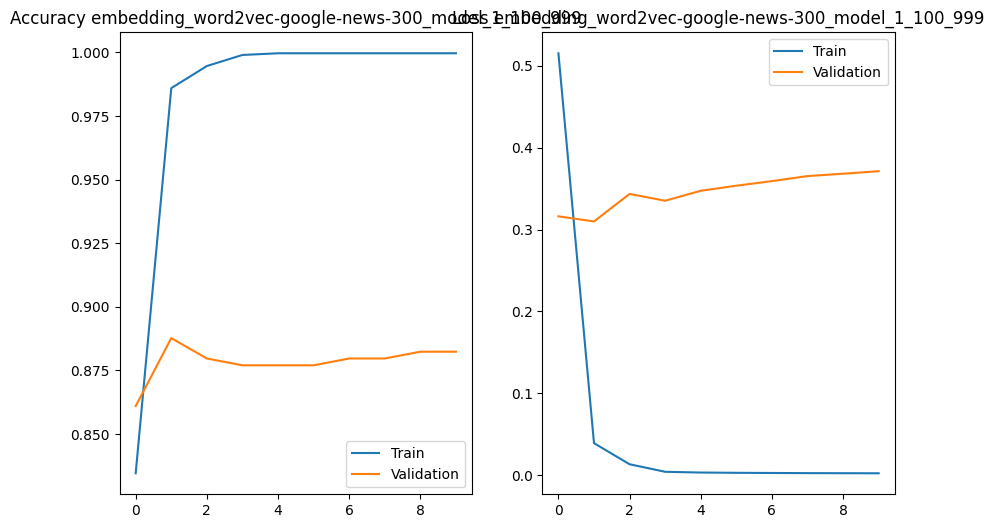

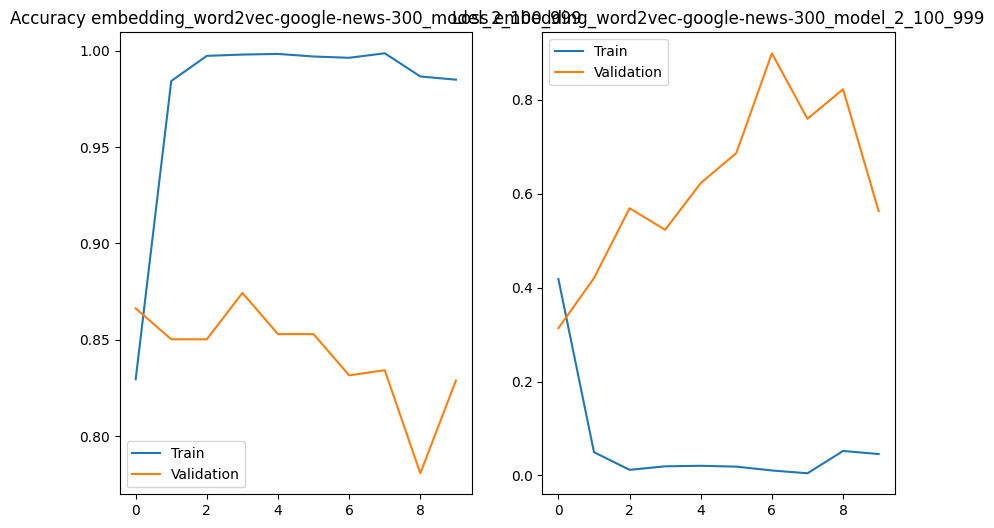

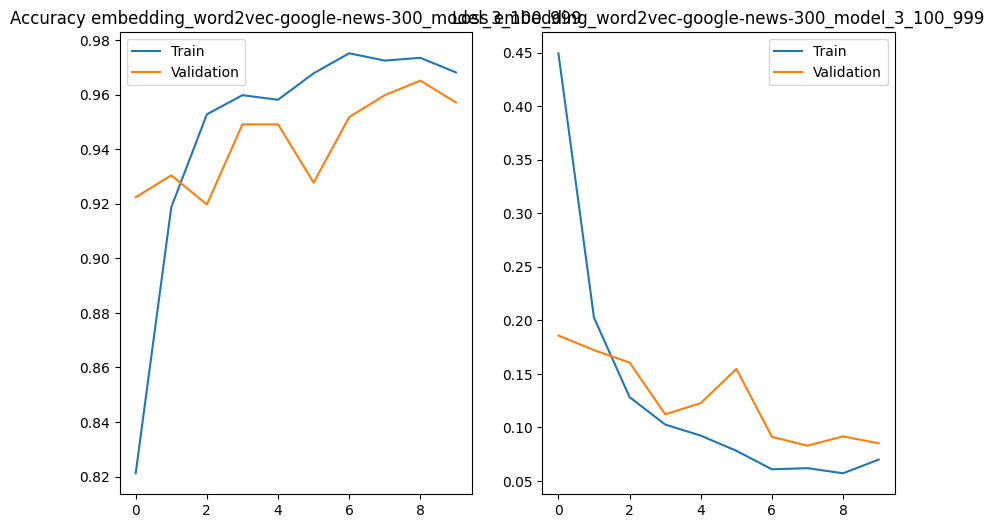

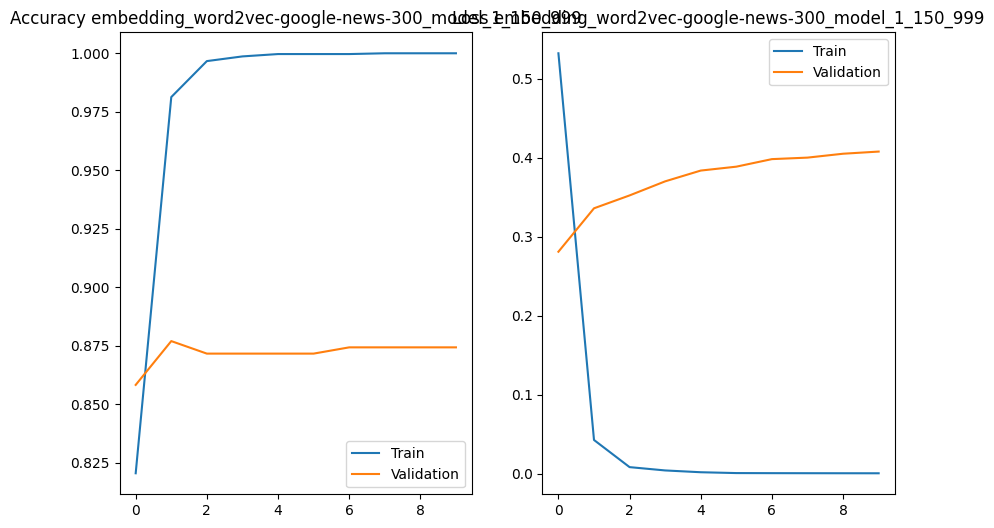

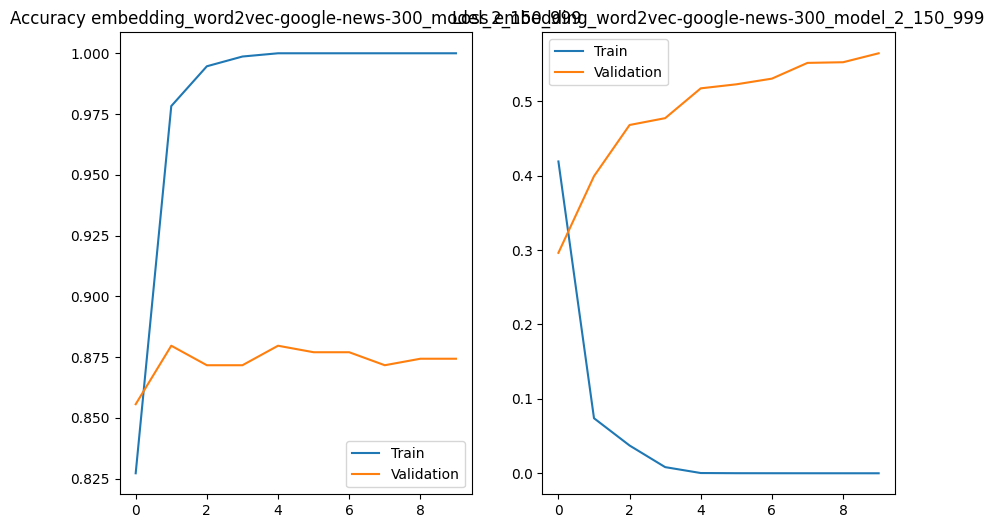

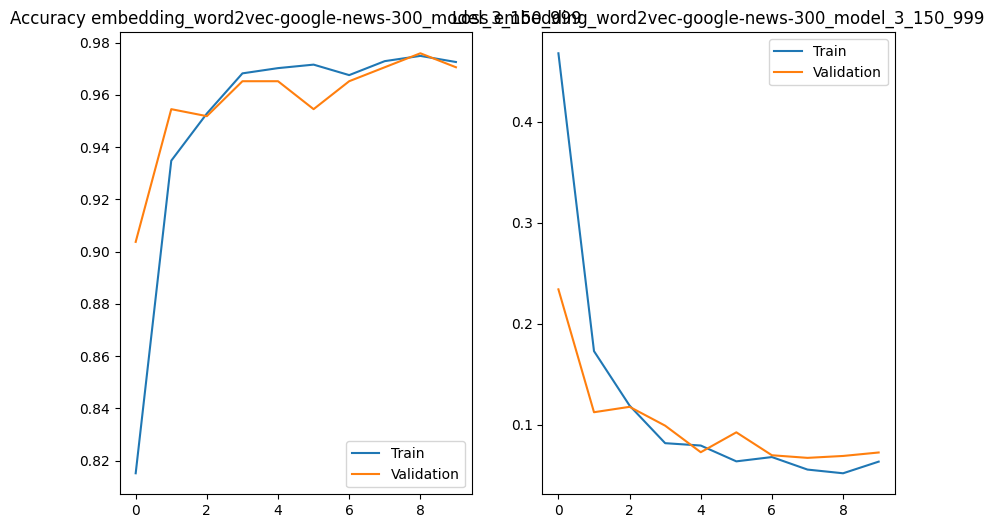

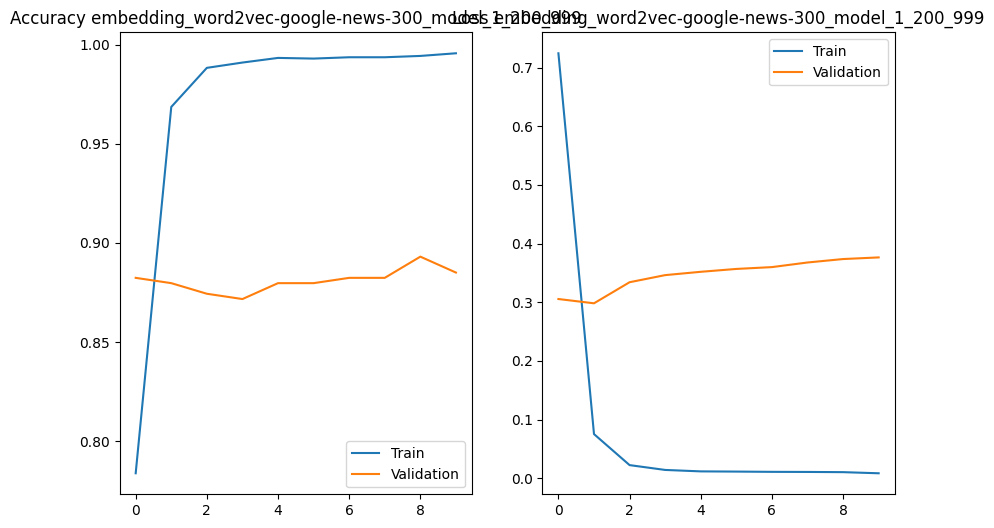

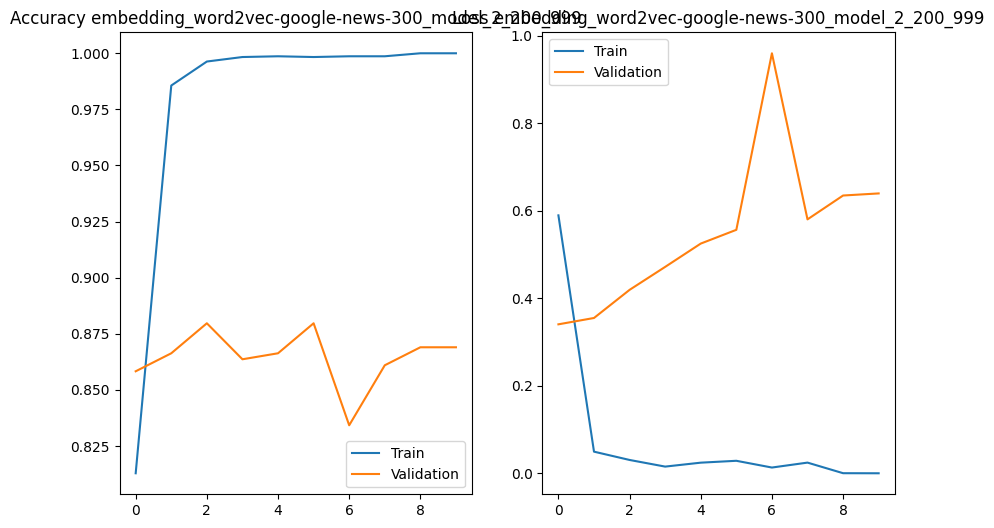

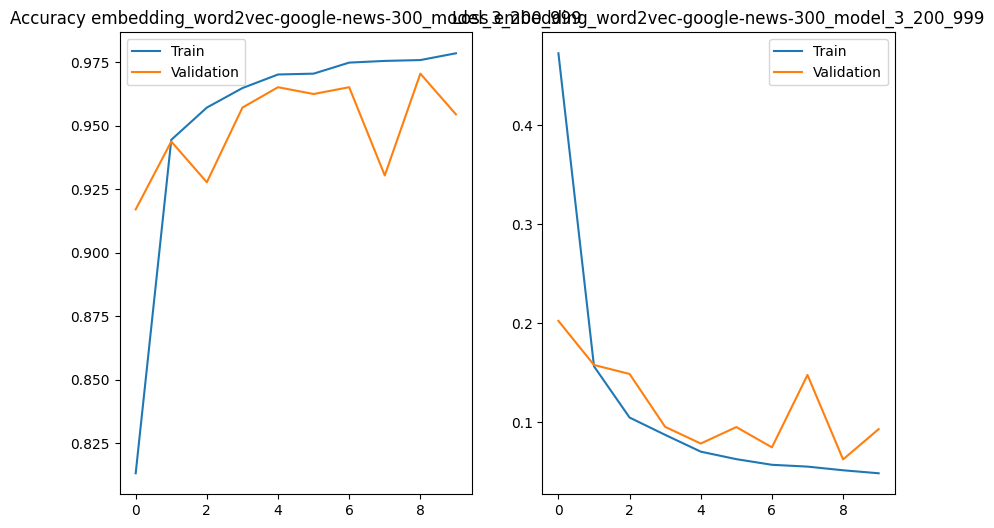

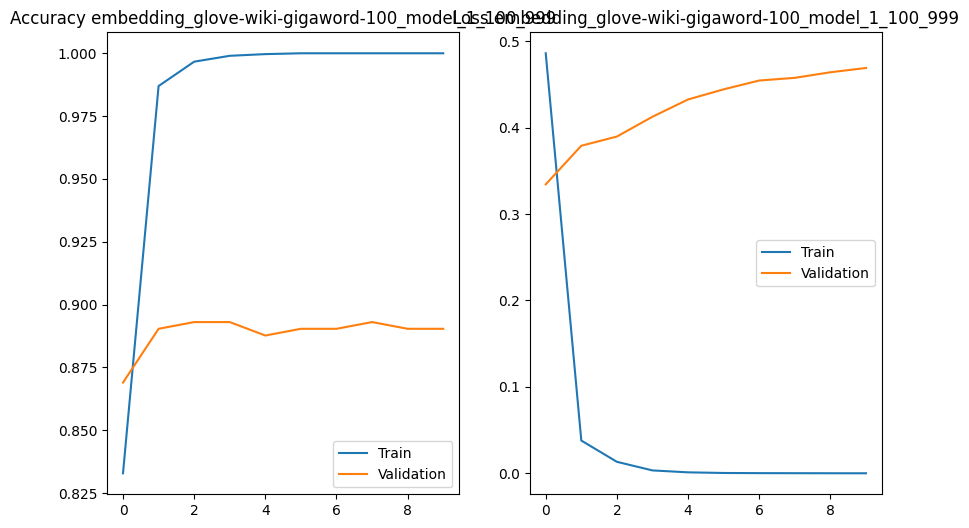

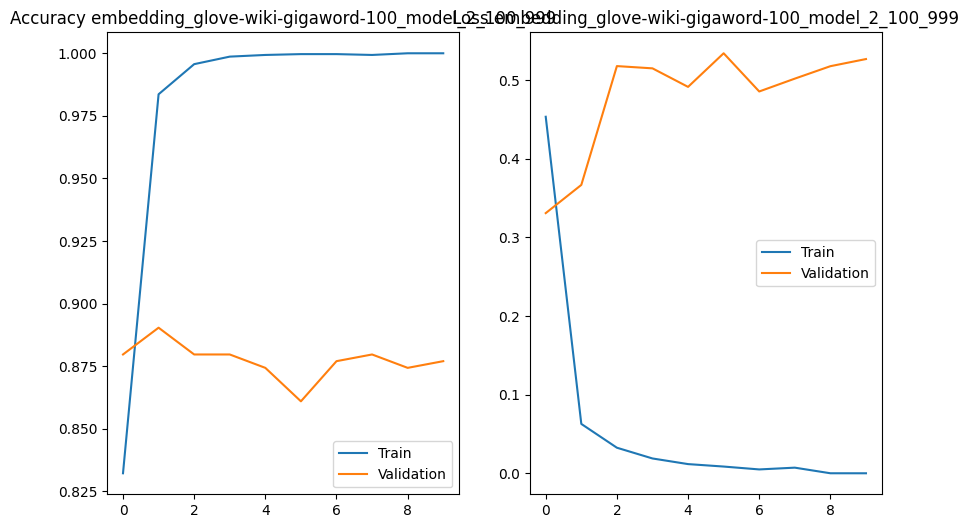

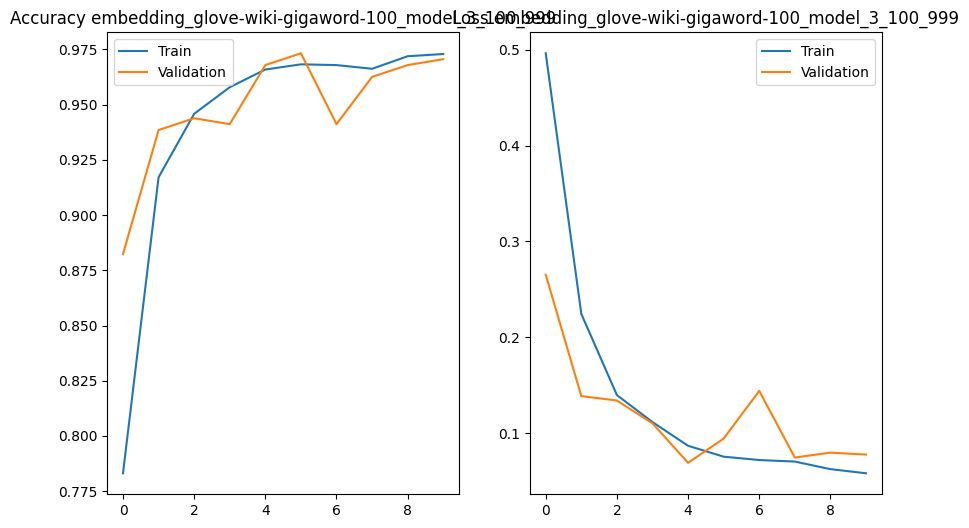

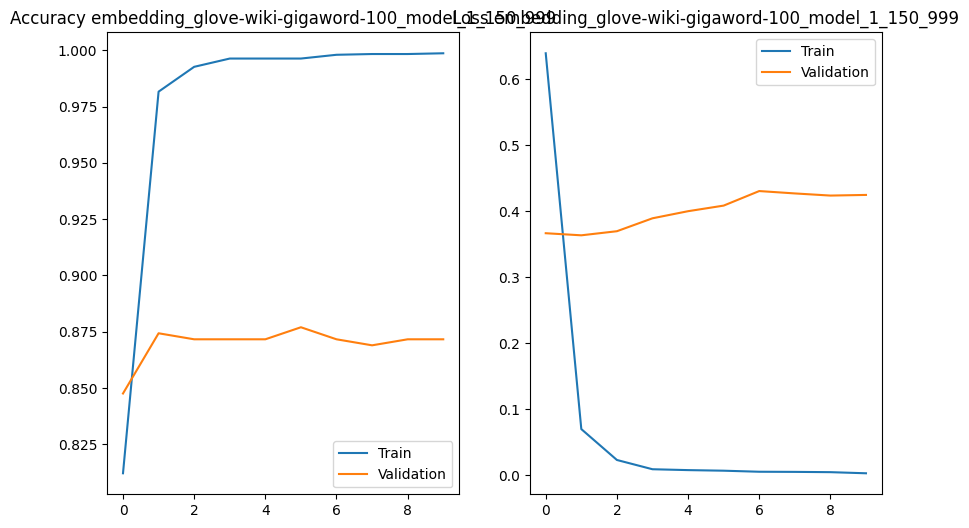

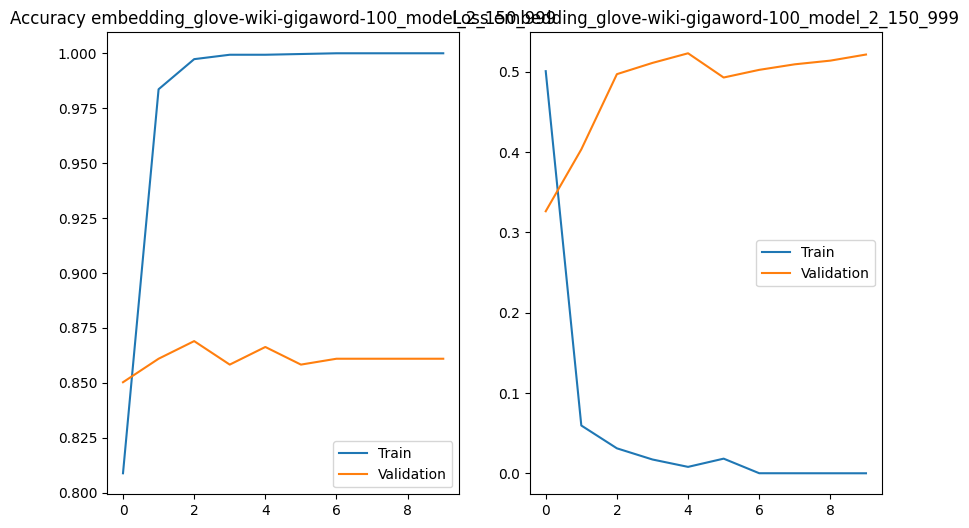

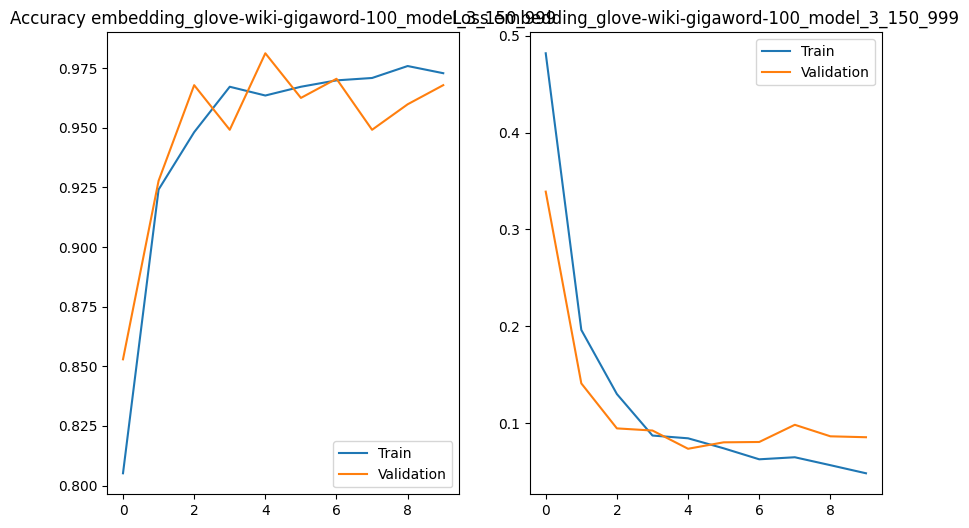

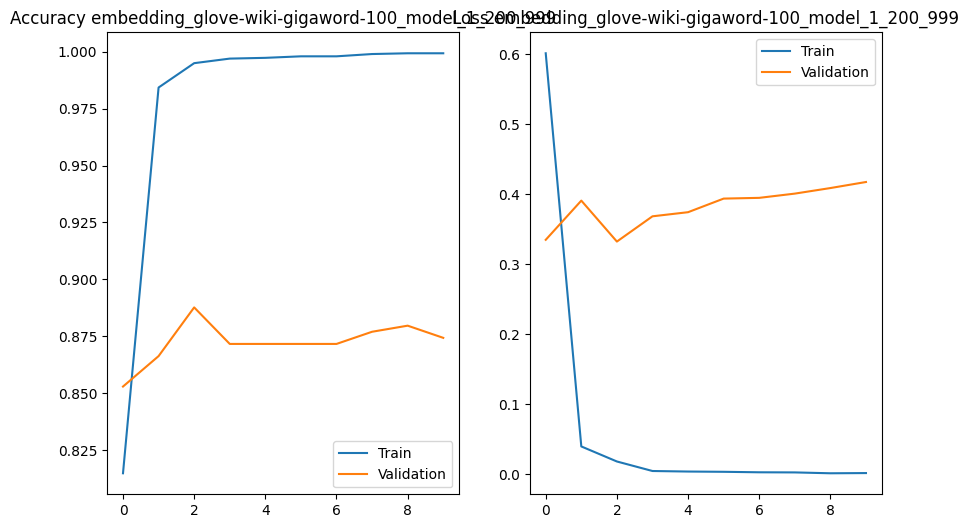

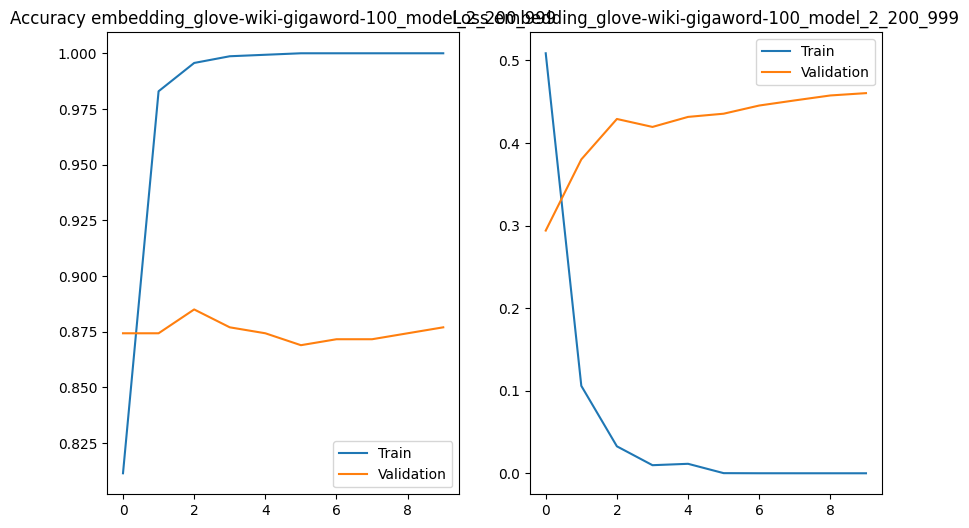

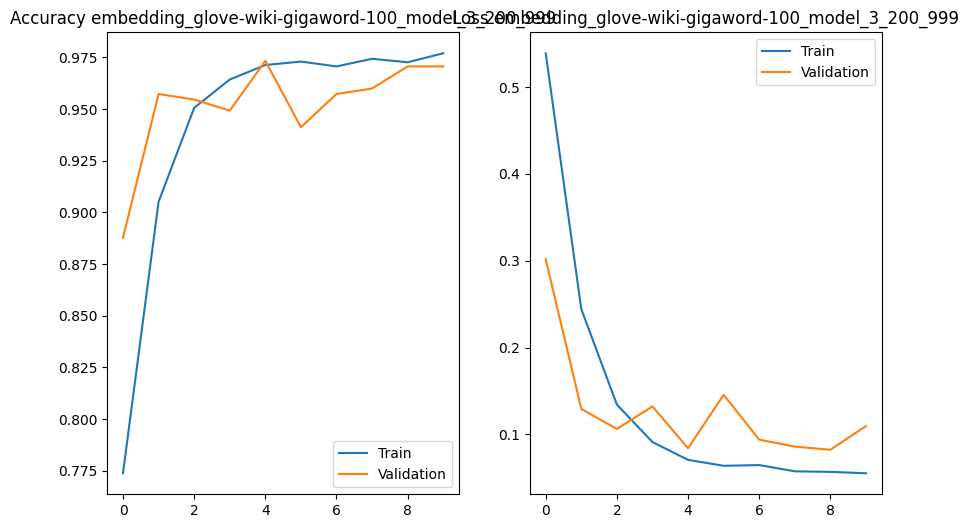

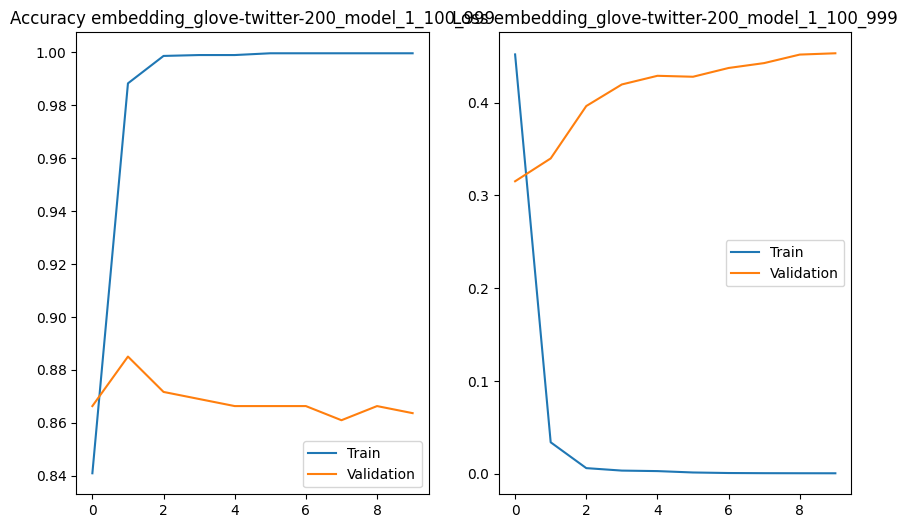

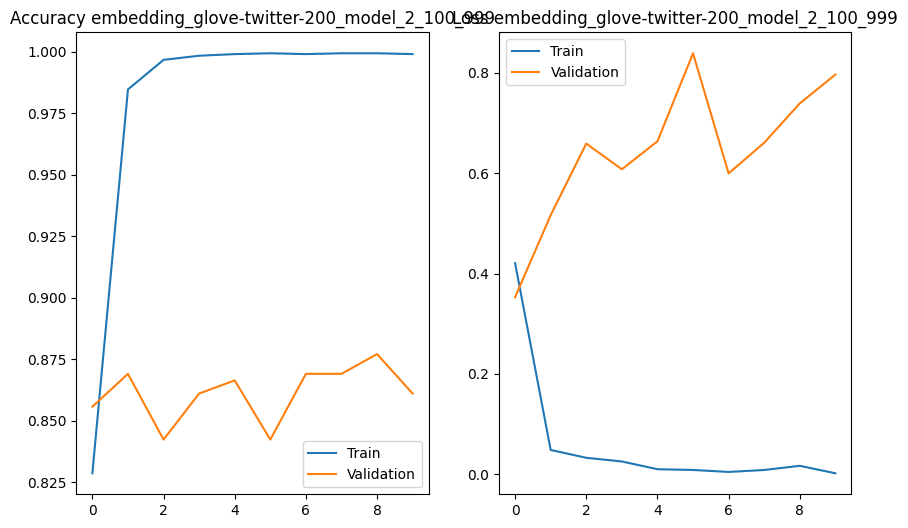

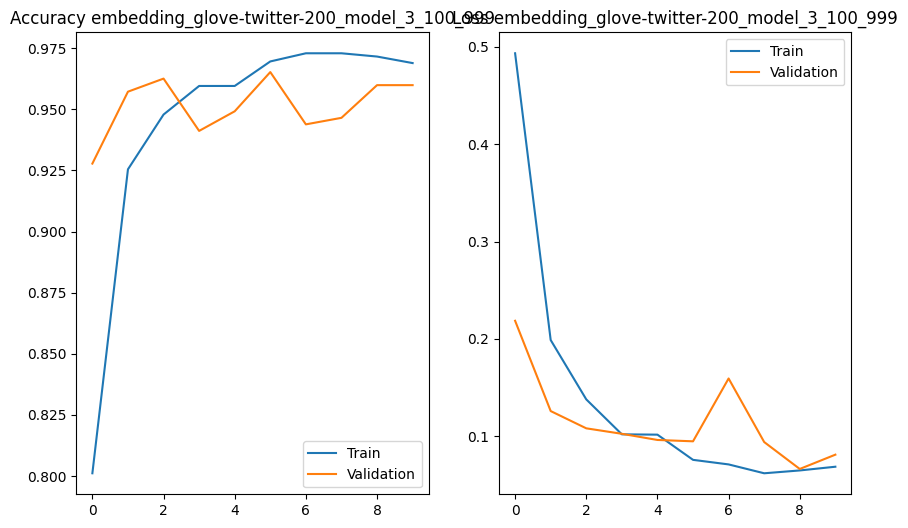

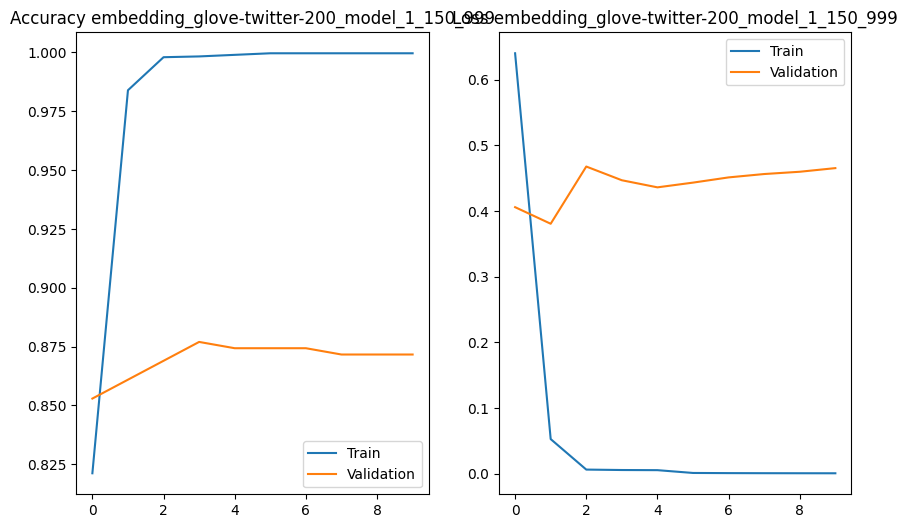

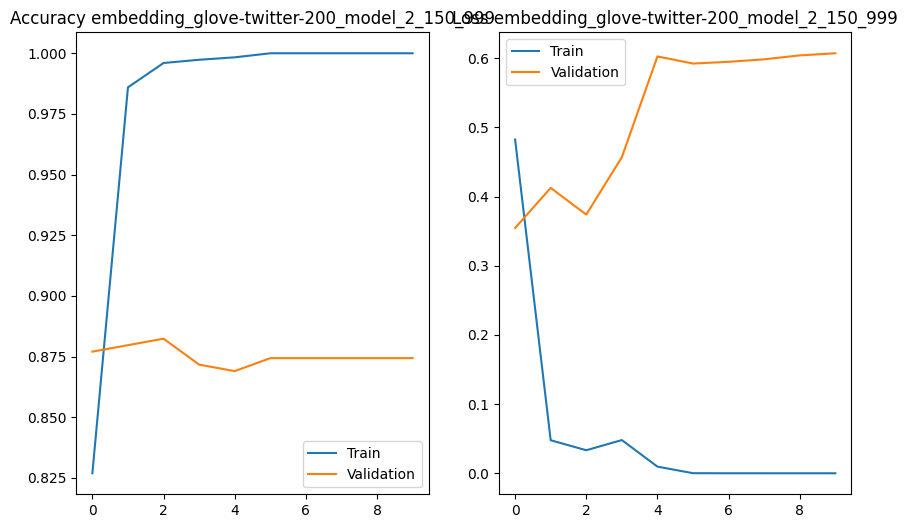

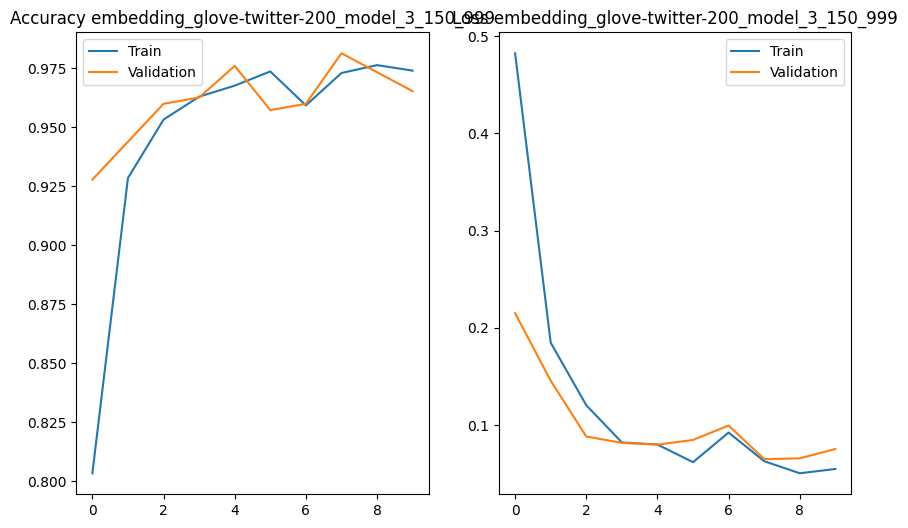

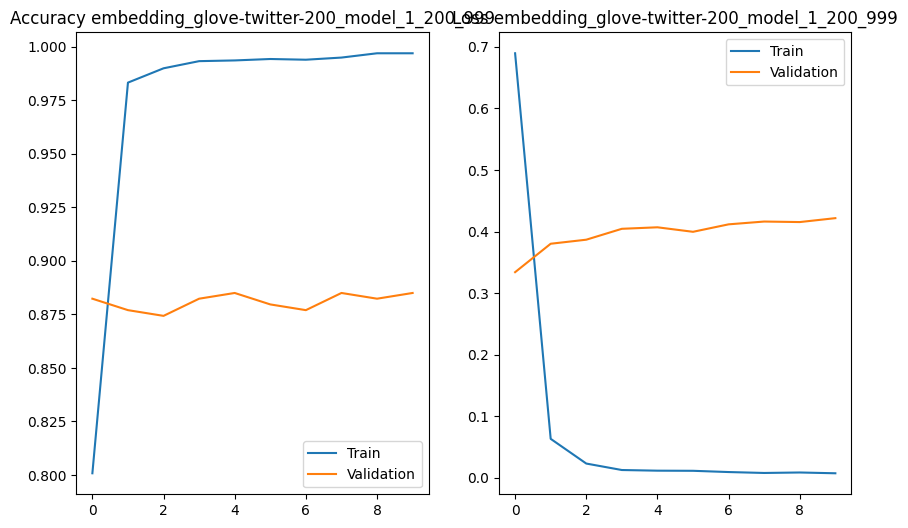

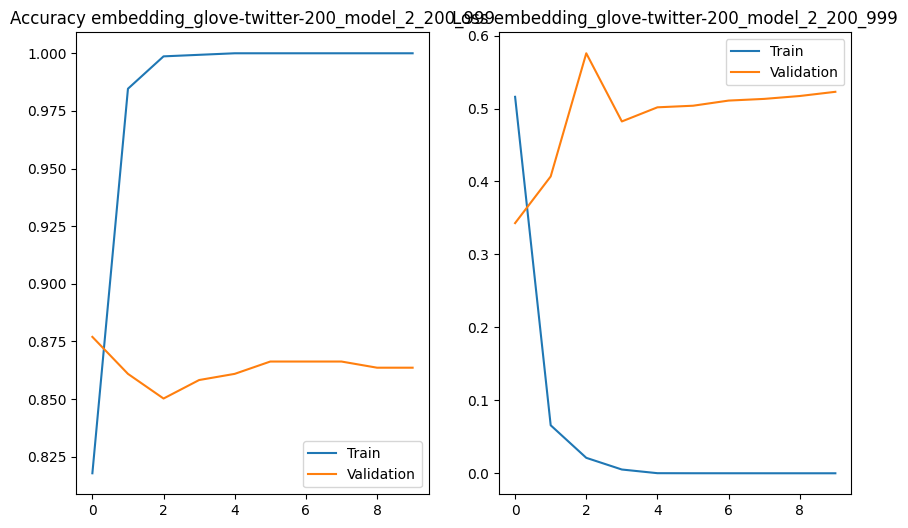

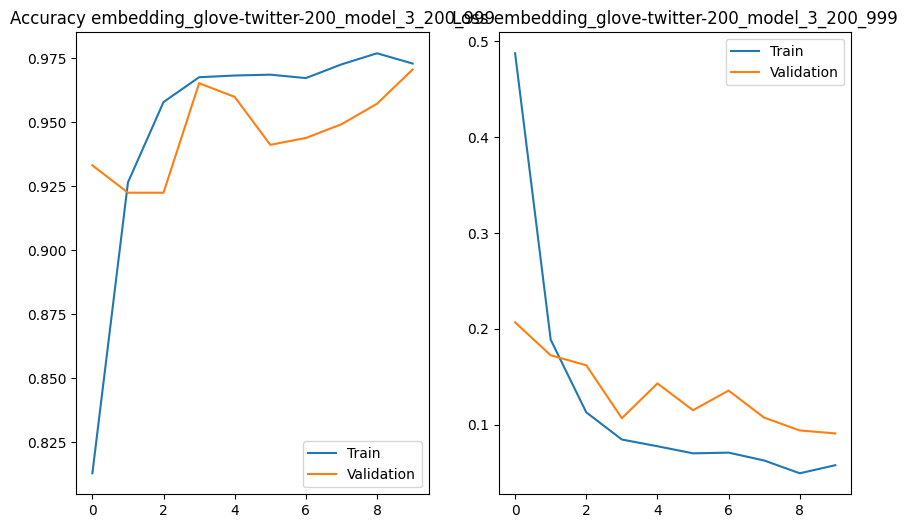

In [48]:
%%time
for embeddings_index in embeddings_matrices:
    index = embeddings_matrices.index(embeddings_index)
    print("----------- EMBEDDINGS",names[index],"-----------")
    for embedding_dim in dimensionalities:
        print("-----------------------------------")
        print("Dimentionality", embedding_dim)
        for model_kind in ['1','2','3']: # TODO: agregar '3'

            segment_size = len(train_segments[0])
            epochs = 10
            batch_size = 32
            trainable = False
            # create a weight matrix for words in training docs
            embedding_matrix = np.zeros((vocab_size, embedding_dim))

            for word, i in tokenizer.word_index.items():
                embedding_vector = embeddings_index.get(word)
                if embedding_vector is not None:
                    embedding_matrix[i] = embedding_vector

            model, history = generate_trained_model(model_kind, embedding_dim, train_segments, train_labels, val_segments, val_labels, epochs, batch_size, trainable, embedding_matrix)
            accuracy, precision, recall, f1, confusion_matrix = evaluate_model(model, test_sequences, test_labels, label_mapping, segment_size)
            print(f"Test accuracy for model {model_kind} with embedding dimension {embedding_dim}: {accuracy:.4f}")
            print()

            # Create a directory to save the model
            model_dir = f"embedding_{names[index]}_model_{model_kind}_{embedding_dim}_{group_code}"
            os.makedirs(model_dir, exist_ok=True)
            model.save(os.path.join(model_dir, "model.h5"))


            # Plot and save the history
            plot = plot_history(history, os.path.join(model_dir, "history.png"),model_dir)

            # Save history as text
            with open(os.path.join(model_dir, "history.txt"), 'w') as f:
                f.write(str(history.history))

            # Save confusion matrix as text
            with open(os.path.join(model_dir, "confusion_matrix.txt"), 'w') as f:
                f.write(str(confusion_matrix.numpy()))

            # Save metrics the metrics as text
            with open(os.path.join(model_dir, "metrics.txt"), 'w') as f:
                f.write(f"Accuracy: {accuracy:.4f}\n")
                f.write(f"Precision: {precision:.4f}\n")
                f.write(f"Recall: {recall:.4f}\n")
                f.write(f"F1: {f1:.4f}\n")
        print()